In [16]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
from tqdm.notebook import tqdm
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
import os
from torchvision import datasets
import torchvision.transforms as transforms

import re

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [8]:
df = pd.read_csv('PokemonStats.csv')

In [149]:
# Helper functions
def get_type_using_pokemon_name(pokemon):
    row = df[df['Pokemon'] == pokemon]['Type']

    if len(row):
        return row.values[0].split(', ')
    return None
def imshow(img):
    plt.imshow(np.transpose(img/2+0.5, (1, 2, 0)))



In [150]:
# Handling multiLabelBinarizer
classes = list(set([tt for typex in list(df['Type']) for tt in typex.split(", ")]))
classes = [[c] for c in classes]

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit(classes)

temp = mlb.transform([["Ice", "Fire",]])
print("Encoded = ", temp)

decoded = mlb.inverse_transform(temp)
print("Decoded = ",decoded)

Encoded =  [[0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0]]
Decoded =  [('Fire', 'Ice')]


In [386]:
# Defining the custom image dataset
from torchvision.datasets import ImageFolder
class CustomImageDataset(ImageFolder):
    def __init__(self, root, transform=None):
        self.root_dir = root
        self.transform = transform
        super().__init__(self.root_dir, self.transform)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)

        # get_type_using_pokemon_name(self.samples[index].split('/')[1])
        pokemon = self.samples[index][0].split('/')[1]
        label = get_type_using_pokemon_name(pokemon)
        if label is None:
            return sample, mlb.transform([""])

        return sample, mlb.transform([label])

In [387]:

print(get_type_using_pokemon_name("Aegislash (Blade Forme)"))
print(get_type_using_pokemon_name("Abomasnow"))


None
['Grass', 'Ice']


In [388]:
#generating the custom datasets from the Imagefodler

train_dir = "TrainImages"
test_dir = "TestImages"

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = CustomImageDataset(root=train_dir, transform=transform)
test_data = CustomImageDataset(root=test_dir, transform=transform)


In [389]:
mlb.transform([""])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [390]:
train_data[4]

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))

In [391]:
# Split train into train/validation (USING ONLY POKEMONS PRESENT IN THE CSV)

import numpy as np

present_indices = []

for i,c in enumerate(train_data.classes):
    if get_type_using_pokemon_name(c): # using only CSV present pokemons for training for now.
        present_indices.append(i) # appending csv present pookemons in the list.
        
valid_size = 0.2
num_train = len(present_indices)
indices = present_indices
np.random.shuffle(indices)
split = int(np.floor(num_train * valid_size))
train_indices = indices[split:]
valid_indices = indices[:split]

In [392]:
# Using subset randomsampler to use the index to form sampler
from torch.utils.data.sampler import SubsetRandomSampler

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)


In [393]:
for a in train_sampler:
    print(a)

238
157
528
327
447
276
451
66
796
394
63
282
302
825
90
706
37
229
431
331
380
199
546
118
109
478
124
556
646
798
46
161
145
373
812
409
362
736
61
143
787
211
791
799
293
301
259
696
74
104
349
658
465
772
183
497
151
377
741
463
613
727
286
610
833
488
427
688
529
265
637
750
315
129
266
564
111
783
471
200
187
649
725
594
313
436
71
590
219
670
598
673
17
669
357
572
422
801
181
708
837
30
402
698
739
193
662
531
374
761
693
805
640
415
108
607
715
443
776
701
604
83
68
339
460
661
281
27
620
372
249
355
57
324
561
583
644
28
311
742
568
358
326
343
612
757
482
119
440
45
595
268
23
723
169
619
24
492
689
835
589
226
560
128
347
73
120
611
60
816
498
232
731
91
376
47
168
167
212
473
483
256
779
218
214
559
246
654
513
824
260
401
665
629
33
150
192
664
600
64
175
191
234
516
704
407
797
228
227
184
367
382
359
350
515
514
328
186
433
820
464
707
763
832
547
130
1
512
113
687
290
668
127
745
99
694
634
584
608
172
126
652
308
690
384
500
89
545
574
486
773
275
306
521
100
434
14
3

In [434]:
# Using randomsampler to generrate Dataloaders
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=1, sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=1, sampler=valid_sampler)
test_loader = DataLoader(test_data, batch_size=1)


Y:  tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])
Label:  [('Electric', 'Water')]


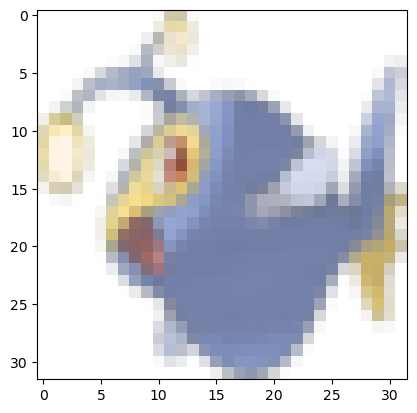

In [435]:
# Check visualize sample data from train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)


# for index in np.arange(32):
print("Y: ", labels[0])
print("Label: ",mlb.inverse_transform(labels[0]))
imshow(images[0])


In [436]:
len(mlb.classes_)

18

In [437]:
# Designing CNN for this dataloader

import torch.nn as nn

class PokemonTypeCNN(nn.Module):
    def __init__(self, num_pokemon_types):
        super(PokemonTypeCNN, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.linear = nn.Sequential(
            nn.Linear(4096, 128),
            nn.ReLU(),
            nn.Linear(128, len(mlb.classes_))  # Adjust output neurons for Pokémon types
        )
        
    def forward(self, x):
        output = self.cnn_layers(x)
        output = output.view(output.size(0), -1)
        output = self.linear(output)
        return output

# Define the number of Pokémon types (classes)
num_pokemon_types = len(mlb.classes_)  # Number of unique Pokémon types encoded by MultiLabelBinarizer

# Create an instance of the model
model = PokemonTypeCNN(num_pokemon_types)


In [438]:
model

PokemonTypeCNN(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=18, bias=True)
  )
)

In [439]:
import torch.optim as optim
criterion = nn.BCEWithLogitsLoss()
optimiser = optim.SGD(model.parameters(), momentum=0.9, lr=0.001)


In [428]:
epochs = 5

train_loss = []
valid_loss = []

for epoch in range(epochs):
    epoch_train_loss = 0.
    model.train()
    for data, target in train_loader:
        # print(data[0], target[0])
        optimiser.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimiser.step()
        epoch_train_loss += loss.item() * data.size(0)
    train_loss.append(epoch_train_loss/len(train_data))
    model.eval()
    
    epoch_valid_loss = 0.
    for data, target in valid_loader:
        output = model(data)
        loss = criterion(output, target)
        epoch_valid_loss += loss.item() * data.size(0)
    valid_loss.append(epoch_valid_loss / 10000.)
    
    print('Epoch', epoch, 'losses:', train_loss[-1], valid_loss[-1])

ValueError: Target size (torch.Size([32, 1, 18])) must be the same as input size (torch.Size([32, 18]))

In [441]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the loss function for multi-label classification
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Using Adam optimizer for optimization

# Define the number of epochs
epochs = 5

# Lists to store training and validation losses
train_loss = []
valid_loss = []

# Training loop
for epoch in range(epochs):
    epoch_train_loss = 0.
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data[0])
        loss = criterion(output, target[0].float())  # Convert target to float for BCEWithLogitsLoss
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * data[0].size(0)
    train_loss.append(epoch_train_loss / len(train_loader.dataset))
    
    model.eval()
    epoch_valid_loss = 0.
    with torch.no_grad():
        for data, target in valid_loader:
            output = model(data[0])
            loss = criterion(output, target[0].float())  # Convert target to float for BCEWithLogitsLoss
            epoch_valid_loss += loss.item() * data.size(0)
    valid_loss.append(epoch_valid_loss / len(valid_loader.dataset))
    
    print('Epoch', epoch, 'Train Loss:', train_loss[-1], 'Valid Loss:', valid_loss[-1])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x256 and 4096x128)